# Introduction

This report will analyse the following filter, creating a bode plot, analysing it's step response and comparing to simulations made in LT-spice.

![Circuit Diagram of filter](assets/images/circuit.png)

# Transfer function

The transfer function of an LTI-system describes the relationship between the input and output of the system. Finding it is the first step in describing the circuit. We will do this by using the impedence $Z$. 

## Impedence 

Inorder to easily find the transfer function we will define a property called *impedence* for each of our components. We define it as: $$Z = \frac{u}{i}$$

and proceed to find this property for each of our components.

### Resistor

The impedence of the resistor can be found using Ohm's law:

$$u = R \cdot i \Leftrightarrow Z = \frac{u}{i} = R$$

### Capacitor

The capacitors can also be found by a similar method, using the definition of capacitance:

$$Q = C \cdot U \Rightarrow i(t) = C \cdot \frac{d u(t)}{dt}$$

$$\Leftrightarrow du(t) = \frac{1}{C} \cdot i(t) \, dt$$

$$\Leftrightarrow u(t) = \frac{1}{C} \cdot \int_0^t i(t) \, dt$$

Laplace-transforming this we get:

$$U(s) = \frac{1}{C} \cdot s^-1 \cdot I(s) + \frac{u(0)}{sC}$$

**Assumption:** at time t=0 the transistor is uncharged, therefore $u(0) = 0$ V.

$$\Rightarrow Z = \frac{U(s)}{I(s)} = \frac{1}{sC}$$

### Inductor



## Derivation

Using voltage division we find that:

$$u_1 = u_0 \cdot \frac{Z_R}{Z_C || Z_L + Z_R}$$

To make our life easier, let's first simplify our parallel replacement resistance $Z_R || Z_L$:

$$\Rightarrow Z_C || Z_L = \left( sC + \frac{1}{sL} \right)^{-1} = \frac{sL}{s^2CL + 1}$$

Now inserting (Note: $Z_R = R$):

$$\Rightarrow \frac{u_1}{u_0} = \frac{R}{\frac{sL}{s^2CL + 1} + R} = \frac{R}{\frac{sL + R(s^2CL+1)}{s^2CL + 1}} = \frac{R(s^2CL + 1)}{R(s^2CL + 1) + sL} = H(s)$$

This is our transfer function, using it we can describe our system.

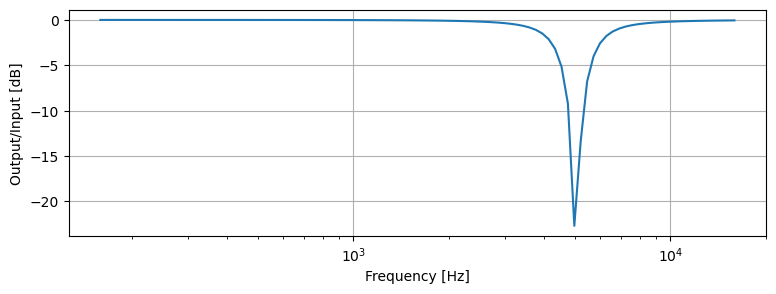

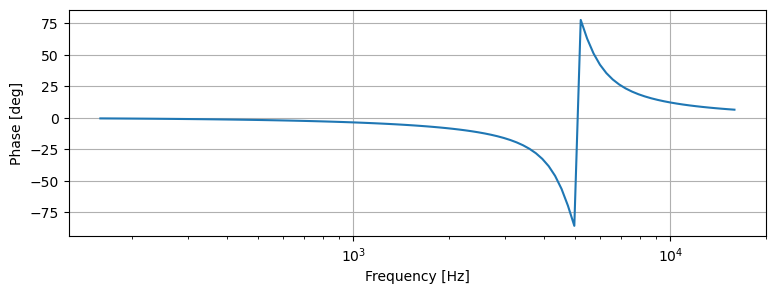

In [5]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

R = 5000
C = 20 * 10**(-9)
L = 50 * 10**(-3)

numerator = [C*L*R, 0, R]
denominator = [C*L*R, L, R]

LTI = signal.TransferFunction(numerator,denominator)

w, mag, phase = signal.bode(LTI)

# Convert rad/s to Hz
f=w/(2*np.pi)

plt.figure(figsize=(9, 3), dpi=100)
plt.semilogx(f,mag)
#plt.hlines(-3,min(f),max(f),linestyles="dotted",colors='r')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Output/Input [dB]')
plt.grid()
plt.figure(figsize=(9, 3), dpi=100)
plt.semilogx(f, phase)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [deg]')
plt.grid()
plt.show()

See handwritten note for expression for step response. The basics are that we use a convolution of the Heavyside function with the impulse response for our LTI-system. We don't know and don't need to know the impulse response, we use the Laplace Transform to find the laplace transform of the step response and then invert it to find the actual step response. 

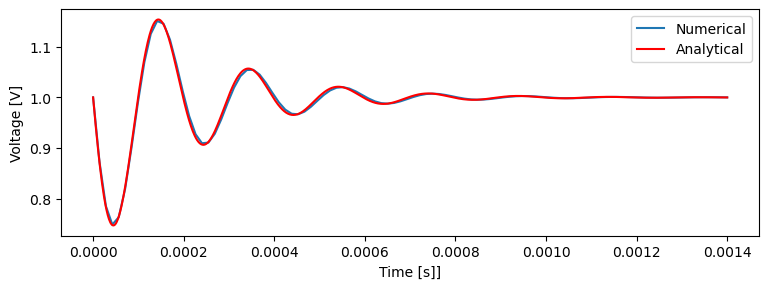

In [48]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

R = 5000
C = 20 * 10**(-9)
L = 50 * 10**(-3)

numerator = [C*L*R, 0, R]
denominator = [C*L*R, L, R]

LTI = signal.TransferFunction(numerator,denominator)
tDataLTI, yDataLTI = signal.step(LTI)

# Analytical expression
a = - 1 / (2*R*C)
b = np.sqrt(np.abs(L-4*R ** 2 * C /(4* R **2 * C ** 2 * L)))
c = np.sqrt(np.abs(L ** 2 - 4 * R ** 2 * C * L))

calcResponse = lambda t : 1 - 2*L / (c) * np.exp(t*a) * np.sin(b * t)

# Plot function

tInput = np.linspace(min(tDataLTI),max(tDataLTI),1000)

plt.figure(figsize=(9, 3), dpi=100)
plt.plot(tDataLTI, yDataLTI, label='Numerical')
plt.plot(tInput, calcResponse(tInput), color='r', label='Analytical')
plt.legend()
plt.xlabel('Time [s]]')
plt.ylabel('Voltage [V]')
#plt.grid()
plt.show()

The next part of the assignment is to calculate the output from with each of the first five terms in a square wave fourier-series. The period of the square wave used here is $T = 0.2 \textrm{ ms} = 2 \cdot 10^{-4} \textrm{ s}$, which corresponds to $\omega = \frac{2\pi}{2 \cdot 10^{-4}} \textrm{ rad/s}$.

$$ $$

       f_i       A_i      A_oi       B_oi
1   5000.0  0.636620  0.026401 -87.623234
2  15000.0  0.212207  0.210706   6.818127
3  25000.0  0.127324  0.127045   3.796073
4  35000.0  0.090946  0.090848   2.658504
5  45000.0  0.070736  0.070690   2.051216


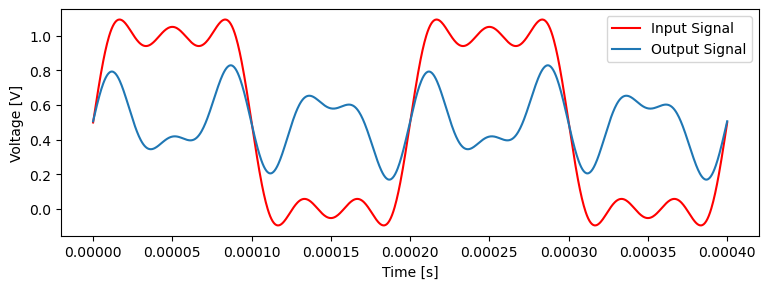

In [9]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import pandas as pd

R = 5000
C = 20 * 10**(-9)
L = 50 * 10**(-3)
T0 = 2 * 10**(-4)

numerator = [C*L*R, 0, R]
denominator = [C*L*R, L, R]

# Functions to find square wave fourier terms
SwaveFrq = lambda n : (2*n-1)*2*np.pi/T0
SwaveAmp = lambda n : 2/(np.pi * (2*n-1))
Swaveterm = lambda n,t : SwaveAmp(n) * np.sin(SwaveFrq(n)*t)

# Function to evaluate transfer function
transferF = lambda s: np.polyval(numerator, s) / np.polyval(denominator, s)

# Create dataframe with information about terms
nterms = 5

df = pd.DataFrame({'f_i' : (SwaveFrq(i)/(2*np.pi) for i in range(1, nterms + 1)),
                   'A_i' : (SwaveAmp(i) for i in range(1, nterms + 1)),
                  'A_oi': (SwaveAmp(i)*np.absolute(transferF(1j*SwaveFrq(i))) for i in range(1, nterms + 1)),
                   'B_oi' : (np.angle(transferF(1j*SwaveFrq(i)), deg=True) for i in range(1, nterms + 1))},
                  index=[i for i in range(1, nterms + 1)])
print(df)

# Preparing for plots
nTerms = 3
maxTime = 0.0004

InSine = lambda n, t : SwaveAmp(n) * np.sin(SwaveFrq(n) * t)
OutSine = lambda n, t : SwaveAmp(n) * np.absolute(transferF(1j*SwaveFrq(n))) * np.sin(SwaveFrq(n) * t + np.angle(transferF(1j*SwaveFrq(n)), deg=False))

tInput = np.linspace(0,maxTime,1000)

# Plotting

plt.figure(figsize=(9, 3), dpi=100)

plt.plot(tInput, 0.5 + sum((InSine(k,tInput) for k in range(1,nTerms+1))), 'r', label='Input Signal')
plt.plot(tInput, 0.5 + sum((OutSine(k,tInput) for k in range(1,nTerms+1))), label='Output Signal')

plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
#plt.grid()
plt.show()

In [4]:
%%latex
\begin{table}[]
\centering
\begin{tabular}{llll}
\multicolumn{1}{l|}{$n$} & \multicolumn{1}{l|}{$A_{in}$} & \multicolumn{1}{l|}{$A_{out}$} & $B_{out}$  \\ \hline
1                        & 1.273240                      & 0.052802                       & -87.623234 \\
2                        & 0.424413                      & 0.421508                       & -6.708195  \\
3                        & 0.254648                      & 0.254105                       & -3.742631  \\
4                        & 0.181891                      & 0.181701                       & -2.622454  \\
5                        & 0.141471                      & 0.141383                       & -2.023828  
\end{tabular}
\end{table}

<IPython.core.display.Latex object>